In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import pickle
from stylesheets.register_roboto import register_roboto
register_roboto()

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D, HandlerPatch
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from torch.distributions import Uniform, Normal
from sbi.inference import FMPE, SNPE

from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.plot.coverage_diagnostics import coverage_probability_plot
from lf2i.utils.other_methods import hpd_region
from lf2i.utils.calibration_diagnostics_inputs import preprocess_predict_p_values

from utils import GaussianMean, DividedPatchHandler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
B = 100_000
B_PRIME = B_DOUBLE_PRIME = EVAL_GRID_SIZE = 50_000
CONFIDENCE_LEVEL = 0.95, 0.683

NORM_POSTERIOR_SAMPLES = None

PRIOR = Normal(loc=torch.Tensor([0]), scale=torch.Tensor([1]))
REFERENCE = Uniform(low=torch.Tensor([-11]), high=torch.Tensor([11]))  # estimate on a slightly larger space to avoid boundary effects
EVAL_GRID_DISTR = Uniform(low=torch.Tensor([-10]), high=torch.Tensor([10]))

In [4]:
simulator = GaussianMean(
    poi_dim=1, 
    prior=PRIOR,
    reference=REFERENCE
)

In [6]:
b_params, b_samples = simulator.simulate_for_test_statistic(size=B)
b_params.shape, b_samples.shape

(torch.Size([100000, 1]), torch.Size([100000, 1]))

In [ ]:
estimator = SNPE(
    prior=simulator.prior,
    density_estimator='maf',
    device='cpu'
)

_ = estimator.append_simulations(b_params, b_samples.reshape(-1, 1)).train()
posterior = estimator.build_posterior()

/Users/luca/miniforge3/envs/vsi/lib/python3.11/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 51 epochs.

In [58]:
with open('pstr_schema.pkl', 'wb') as f:
    pickle.dump(posterior, f)

In [5]:
with open('pstr_schema.pkl', 'rb') as f:
    posterior = pickle.load(f)

In [6]:
obs_theta = torch.Tensor([[4]])
obs_x = simulator.likelihood(obs_theta).sample(sample_shape=(1, )).squeeze(0)
prior_samples = simulator.prior.sample(sample_shape=(100_000, ))
posterior_samples = posterior.sample(sample_shape=(100_000, ), x=obs_x.reshape(1, ))

Drawing 100000 posterior samples for 1 observations:   0%|          | 0/100000 [00:00<?, ?it/s]

In [7]:
credible_sets = []
for cl in CONFIDENCE_LEVEL:
    credible_set = hpd_region(
        posterior=posterior,
        param_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
        x=obs_x.reshape(-1, ),
        credible_level=cl,
        num_level_sets=10_000,
        norm_posterior=NORM_POSTERIOR_SAMPLES
    )[1].numpy()
    credible_sets.append(credible_set)

In [59]:
def plot1(axis = None):
    plt.rc('text', usetex=True)  # Enable LaTeX
    plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
    plt.rcParams['text.latex.preamble'] = r'''
        \usepackage{amsmath}  % For \mathbb
        \usepackage{amssymb}  % For \mathbb
        \usepackage{bm}       % For bold math symbols
        \usepackage{underscore} % If underscores are needed
    '''

    if axis is None:
        fig = plt.figure(figsize=(8.5, 5))
        ax = fig.gca()
    else:
        ax = axis
    posterior_color = 'purple'
    prior_color = 'lightgrey'
    truth_color = 'crimson'

    ### DENSITIES
    sns.kdeplot(prior_samples, ax=ax, color=prior_color, linewidth=2, zorder=10, linestyle='-')
    kde_posterior = sns.kdeplot(posterior_samples, ax=ax, color='black', linewidth=2, zorder=30)

    ### BOX for HPD SET(s)
    colors = [posterior_color, 'hotpink']
    posterior_line = kde_posterior.get_lines()[-1]
    x_posterior = posterior_line.get_xdata()
    y_posterior = posterior_line.get_ydata()
    pos_rectangle_offset, neg_rectangle_offset = 0.02, -0.02
    for i, cl in enumerate(CONFIDENCE_LEVEL):
        credible_min = credible_sets[i].min()
        credible_max = credible_sets[i].max()
        intersect_point = np.interp([credible_min, credible_max], x_posterior, y_posterior)

        ax.plot([credible_min, credible_max], [pos_rectangle_offset]*2, transform=ax.get_xaxis_transform(), color=colors[i], linewidth=4, zorder=50, clip_on=False)
        ax.plot([credible_min, credible_max], [neg_rectangle_offset]*2, transform=ax.get_xaxis_transform(), color=colors[i], linewidth=4, zorder=50, clip_on=False)
        ax.vlines(
            [credible_min, credible_max], ymin=[neg_rectangle_offset]*2, ymax=[pos_rectangle_offset]*2, 
            transform=ax.get_xaxis_transform(), color=colors[i], linewidth=4, zorder=50, clip_on=False
        )
        ax.fill_between(
            [credible_min, credible_max], neg_rectangle_offset, pos_rectangle_offset, 
            transform=ax.get_xaxis_transform(), color=colors[i], alpha=0.3, zorder=50, clip_on=False
        )
        if i == 0:
            ax.fill_between(  # opaque patch underneath to avoid seeing axis etc ...
                [credible_min, credible_max], neg_rectangle_offset, pos_rectangle_offset, 
                transform=ax.get_xaxis_transform(), color="white", alpha=1.0, zorder=49, clip_on=False
            )
        ### PROJECTION LINES
        ax.vlines(
            x=[credible_min, credible_max], ymin=0, ymax=intersect_point, 
            color=colors[i], linestyle=':', linewidth=3, zorder=29
        )
        ### SHADING UNDER POSTERIOR FOR HPD
        ax.fill_between(
            x_posterior,
            intersect_point[0],
            y_posterior,
            where=(x_posterior >= credible_min) & (x_posterior <= credible_max),
            color=colors[i],
            alpha=0.4,
            zorder=28+i,
            linestyle='--'
        )
        # posterior level-set lines for HPDs
        ax.hlines(y=intersect_point[0], xmin=((credible_sets[0].min()+credible_sets[0].max())/2)-2.9, xmax=((credible_sets[0].min()+credible_sets[0].max())/2)+2.9, linestyle='--', linewidth=2, color=colors[i], zorder=28+i)
        ax.text(
            ((credible_sets[0].min()+credible_sets[0].max())/2)+3.05, intersect_point[0], s=r'$c_{sub}$'.format(sub=i+1),
            horizontalalignment='left', verticalalignment='center', zorder=50, fontdict={'size': 20}
        )
        # TEXT FOR CONFIDENCE LEVEL
        ax.text(
            (credible_min+credible_max)/2, intersect_point[0]+(0.07 if i == 1 else 0.12), s=f'{cl*100:.0f}\%', 
            horizontalalignment='center', verticalalignment='center', zorder=50, fontdict={'size': 20}
        )

    ### TRUTH
    ax.axvline(x=obs_theta.reshape(1, ).numpy(), ymin=0, ymax=0.96, color=truth_color, linestyle='--', linewidth=4, zorder=30)
    ax.scatter(obs_theta.reshape(1, ).numpy(), 0, transform=ax.get_xaxis_transform(), marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=50, clip_on=False)
    ax.scatter(obs_theta.reshape(1, ).numpy(), 0, transform=ax.get_xaxis_transform(), marker='*', facecolor='none', edgecolor=truth_color, s=300, linewidth=2, zorder=50, clip_on=False)

    # text labelling prior and posterior    # r'$\pi(\theta)$'     # r'$\widehat{\pi}(\theta \mid X_{obs})$'
    ax.text(-0.85, 0.68, s=r'Prior', transform=ax.get_xaxis_transform(), horizontalalignment='center', verticalalignment='center', zorder=50, fontdict={'size': 22})
    ax.text(-0.9, 0.92, s=r'Estimated Posterior', transform=ax.get_xaxis_transform(), horizontalalignment='center', verticalalignment='center', zorder=50, fontdict={'size': 22})

    # Set colors manually using matplotlib
    ax.get_lines()[0].set_color(prior_color)
    ax.get_lines()[1].set_color('black')

    ax.set_ylabel('Probability Density', size=25)
    #ax.set_xlabel(r'$\theta$', size=25, loc='right', labelpad=-27)
    ax.text(0.9915, 0.06, r'$\theta$', size=25, ha='right', va='center', zorder=100, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black',  boxstyle='round,pad=0.12',  linewidth=0))
    ax.set_xlim(-7, 7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    ax.spines['top'].set_visible(False)  
    ax.spines['right'].set_visible(False)  
    #ax.spines['left'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['bottom'].set_zorder(40)
    ax.plot(7, 0, ">k", transform=ax.get_xaxis_transform(), clip_on=False, markersize=10, zorder=101) 
    ax.plot(-7, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False, markersize=10) 

    # Create a custom patch for the HPD set rectangle and add it to the legend
    hpd_patch = mpatches.Patch(label='HPD Sets')
    truth_handle = Line2D([], [], color=truth_color, linestyle="--", linewidth=4, marker="*", markersize=20, markerfacecolor="white", markeredgecolor="crimson", markeredgewidth=2, label=r"True $\theta^{\star}$")

    # Add custom legend entries
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[:-1] + [hpd_patch, truth_handle]
    labels = labels[:-1] + ['HPD Sets', r"True $\theta^{\star}$"]
    ax.legend(
        handles=handles, labels=labels,
        handler_map={hpd_patch: DividedPatchHandler(edgecolors=[posterior_color, 'hotpink'], facecolors=[(0.824, 0.702, 0.839, 1.0), (0.973, 0.827, 0.906, 1.0)], num_patches=2)}, 
        loc='lower left', prop={'size': 22}, framealpha=0.9, handlelength=2,
    ).set_zorder(11)

    if axis is None:
        plt.savefig('schema_posterior.pdf', bbox_inches='tight')
        plt.show()
    else:
        return ax

In [11]:
b_prime_params, b_prime_samples = simulator.simulate_for_critical_values(size=B_PRIME)
b_prime_params.shape, b_prime_samples.shape

(torch.Size([50000, 1]), torch.Size([50000, 1]))

In [9]:
with open('lf2i_obj_schema.pkl', 'rb') as f:
    lf2i = pickle.load(f)

In [11]:
lf2i = LF2I(
    test_statistic=Posterior(
        poi_dim=1, estimator=posterior, norm_posterior=NORM_POSTERIOR_SAMPLES
    )
)

In [ ]:
confidence_sets = lf2i.inference(
    x=obs_x,
    evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
    confidence_level=CONFIDENCE_LEVEL,
    calibration_method='p-values',
    calibration_model='cat-gb',
    calibration_model_kwargs={'iterations': 1000, 'depth': 9},
    calibration_model_kwargs={
        'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
        'n_iter': 25
    },
    T_prime=(b_prime_params, b_prime_samples),
    num_augment=10
)


Constructing confidence regions ...


Evaluating posterior for 1 points ...: 100%|██████████| 1/1 [00:09<00:00,  9.03s/it]


In [188]:
with open('lf2i_obj_schema.pkl', 'wb') as f:
    pickle.dump(lf2i, f)

In [11]:
eval_grid = simulator.reference.sample(sample_shape=(EVAL_GRID_SIZE, ))
posterior_xobs = posterior.log_prob(theta=eval_grid, x=obs_x, norm_posterior=NORM_POSTERIOR_SAMPLES)
p_values = lf2i.calibration_model['multiple_levels'].predict_proba(
    X=preprocess_predict_p_values('confidence_sets', posterior_xobs, eval_grid, lf2i.calibration_model['multiple_levels'])
)[:, 1]

In [57]:
def plot2(axis = None):
    plt.rc('text', usetex=True)  # Enable LaTeX
    plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
    plt.rcParams['text.latex.preamble'] = r'''
        \usepackage{amsmath}  % For \mathbb
        \usepackage{amssymb}  % For \mathbb
        \usepackage{bm}       % For bold math symbols
        \usepackage{underscore} % If underscores are needed
    '''

    # with plt.style.context("stylesheets/538-roboto.mplstyle"):
    if axis is None:
        fig = plt.figure(figsize=(8.5, 5))
        ax1 = fig.gca()
    else:
        ax1 = axis
    posterior_color = 'purple'
    lf2i_color = 'mediumseagreen'
    calib_color = 'black'
    truth_color = 'crimson'

    # P-VALUES at X_OBS across POI GRID
    sns.lineplot(
        x=eval_grid.numpy().reshape(-1, ), y=p_values, color=calib_color, linewidth=2, zorder=20, ax=axis
        #label=r'$\mathbb{P}_{\mathbf{X} \mid \theta_0}\left( \widehat{\pi}(\theta_0 \mid \mathbf{X}) < \widehat{\pi}(\theta_0 \mid \mathbf{x}_{\text{obs}}) \right)$'
    )

    # separate text for p-value function
    ax1.text(
            -2.85, 0.93, s=r'P-Value Function', # r'$\widehat{F}\left(\widehat{\pi}(\theta \mid X_{\text{obs}});\theta\right)$',  # r'$\mathbb{P}_{\mathbf{X} \mid \theta_0}\left( \widehat{\pi}(\theta_0 \mid \mathbf{X}) < \widehat{\pi}(\theta_0 \mid \mathbf{x}_{\text{obs}}) \right)$', 
            transform=ax1.get_xaxis_transform(), horizontalalignment='left', verticalalignment='center', zorder=50, fontdict={'size': 22}
    )

    # ALPHA LINES and CONFIDENCE SETS
    linestyles = ['--', '--']
    colors = [lf2i_color, 'yellowgreen']
    pos_rectangle_offset, neg_rectangle_offset = 0.02, -0.02
    for i, cl in enumerate(CONFIDENCE_LEVEL):
        ax1.axhline(y=1-cl, xmin=0.4, xmax=0.955, color='black', linewidth=2, linestyle=linestyles[i], zorder=20)
        ax1.text(
            0.4, 1-cl+0.05, s=r'$\alpha={alpha:.2f}$'.format(alpha=(1-cl)), 
            transform=ax1.get_yaxis_transform(), horizontalalignment='left', verticalalignment='center', zorder=50, fontdict={'size': 20}
        )
        
        sort_idx = np.argsort(eval_grid.numpy().reshape(-1, ))
        ax1.fill_between(
            eval_grid.numpy().reshape(-1, )[sort_idx],
            p_values[sort_idx],
            1-cl,
            where=(p_values[sort_idx] >= 1-cl),  # Shade only between the curves
            color=colors[i],
            alpha=0.4,
            zorder=15
        )

        confset_min = confidence_sets[i][0].min()
        confset_max = confidence_sets[i][0].max()
        ax1.vlines(
            x=[confset_min, confset_max], ymin=[0]*2, ymax=[1-cl]*2,
            color=colors[i], linestyle=':', linewidth=3, zorder=10
        )
        ax1.plot([confset_min, confset_max], [pos_rectangle_offset]*2, transform=ax1.get_xaxis_transform(), color=colors[i], linewidth=4, zorder=103, clip_on=False)
        ax1.plot([confset_min, confset_max], [neg_rectangle_offset]*2, transform=ax1.get_xaxis_transform(), color=colors[i], linewidth=4, zorder=103, clip_on=False)
        ax1.vlines(
            [confset_min, confset_max], ymin=[pos_rectangle_offset]*2, ymax=[neg_rectangle_offset]*2,
            transform=ax1.get_xaxis_transform(), color=colors[i], linewidth=4, zorder=103, clip_on=False
        )
        ax1.fill_between(  # projection rectangle
            [confset_min, confset_max], neg_rectangle_offset, pos_rectangle_offset, transform=ax1.get_xaxis_transform(),
            color=colors[i], alpha=0.3, zorder=103, clip_on=False
        )
        ax1.fill_between(  # opaque patch underneath to avoid seeing axis etc ...
            [confset_min, confset_max], neg_rectangle_offset, pos_rectangle_offset, transform=ax1.get_xaxis_transform(),
            color="white", alpha=1.0, zorder=102, clip_on=False  # opaque "background"
        )
        # ax.text(
        #     (confidence_sets[1][0].min()+confidence_sets[1][0].max())/2, 1-cl+0.1, s=f'{cl*100:.0f}\%', 
        #     horizontalalignment='center', verticalalignment='center', zorder=50, fontdict={'size': 20}
        # )

    # ACCEPTANCE REGION
    # ax.fill_between(
    #     eval_grid.numpy().reshape(-1, )[sort_idx],
    #     1-CONFIDENCE_LEVEL[0],
    #     ax.get_ylim()[1],
    #     color='lightgrey',
    #     alpha=0.2,
    #     hatch='//',
    #     edgecolor='grey',
    #     zorder=10,
    #     label='Acceptance Region'
    # )

    ### TRUTH
    ax1.axvline(x=obs_theta.reshape(1, ).numpy(), ymin=0, ymax=0.96, color=truth_color, linestyle='--', linewidth=4, zorder=19)
    ax1.scatter(obs_theta.reshape(1, ).numpy(), 0, transform=ax1.get_xaxis_transform(), marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=103, clip_on=False)
    ax1.scatter(obs_theta.reshape(1, ).numpy(), 0, transform=ax1.get_xaxis_transform(), marker='*', facecolor='none', edgecolor=truth_color, s=300, linewidth=2, zorder=103, clip_on=False)

    ax1.set_xlim(-7, 7)
    #ax.set_ylim(ax.get_ylim())
    ax1.set_ylabel(r'$\text{Level }\alpha$', size=25)#, loc='top', rotation=0)
    # ax.yaxis.set_label_coords(0.05, 0.95)  # Adjust x, y coordinates to align
    #ax.set_xlabel(r'$\theta$', size=25, loc='right', labelpad=-27, zorder=100)
    ax1.text(0.9925, 0.06, r'$\theta$', size=25, ha='right', va='center', zorder=100, transform=ax1.transAxes, bbox=dict(facecolor='white', edgecolor='black',  boxstyle='round,pad=0.15',  linewidth=0))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.spines['bottom'].set_zorder(101)
    ax1.spines['left'].set_linewidth(2) 
    # ax.spines['left'].set_visible(False) 
    ax1.plot(7, 0, ">k", transform=ax1.get_xaxis_transform(), clip_on=False, markersize=10, zorder=101) 
    ax1.plot(-7, 1, "^k", transform=ax1.get_xaxis_transform(), clip_on=False, markersize=10) 

    # Create a custom patch for the confidence set rectangle and add it to the legend; same for true theta
    confset_patch = mpatches.Patch(label='FreB Sets')
    truth_handle = Line2D([], [], color=truth_color, linestyle="--", linewidth=4, marker="*", markersize=20, markerfacecolor="white", markeredgecolor="crimson", markeredgewidth=2, label=r"True $\theta^{\star}$")

    # Add custom legend entries
    handles, labels = ax1.get_legend_handles_labels()
    handles += [confset_patch, truth_handle]
    labels += ['FreB Sets', r"True $\theta^{\star}$"]
    ax1.legend(
        handles=handles, labels=labels, 
        loc='lower left', prop={'size': 22}, framealpha=0.9, handlelength=2,
        handler_map={confset_patch: DividedPatchHandler(edgecolors=[lf2i_color, 'yellowgreen'], facecolors=[(0.796, 0.906, 0.835, 1.0), (0.890, 0.937, 0.773, 1.0)], num_patches=2)}, 
    ).set_zorder(21)

    if axis is None:
        plt.savefig('schema_vsi.pdf', bbox_inches='tight')
        plt.show()
    else:
        return ax1

In [14]:
b_double_prime_params, b_double_prime_samples = simulator.simulate_for_diagnostics(size=B_DOUBLE_PRIME)
b_double_prime_params.shape, b_double_prime_samples.shape

(torch.Size([50000, 1]), torch.Size([50000, 1]))

In [15]:
diagn_objects = {}
for cl in CONFIDENCE_LEVEL:
    diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset = lf2i.diagnostics(
        region_type='lf2i',
        confidence_level=cl,
        calibration_method='p-values',
        coverage_estimator='splines',
        T_double_prime=(b_double_prime_params, b_double_prime_samples),
    )
    diagn_objects[cl] = (diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset)

Evaluating posterior for 50000 points ...:   0%|          | 121/50000 [00:10<1:20:44, 10.30it/s]WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Evaluating posterior for 50000 points ...: 100%|██████████| 50000/50000 [06:44<00:00, 123.74it/s]


Evaluating posterior for 50000 points ...: 100%|██████████| 50000/50000 [06:

In [ ]:
def plot3(axis = None):
    plt.rc('text', usetex=True)  # Enable LaTeX
    plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
    plt.rcParams['text.latex.preamble'] = r'''
        \usepackage{amsmath}  % For \mathbb
        \usepackage{amssymb}  % For \mathbb
        \usepackage{bm}       % For bold math symbols
        \usepackage{underscore} % If underscores are needed
    '''

    if axis is None:
        fig = plt.figure(figsize=(8.5, 5))
        ax = fig.gca()
    else:
        ax = axis
    # sns.set_style('white')
    colors = ['mediumseagreen', 'yellowgreen']
    linestyles = ['--', ':']

    for i, cl in enumerate([0.95, 0.683]):
        df_plot = pd.DataFrame({
            "parameters": b_double_prime_params.numpy().reshape(-1,),
            "mean_proba": diagn_objects[cl][2].reshape(-1,)*100,
            "lower_proba": diagn_objects[cl][-1].reshape(-1,)*100,
            "upper_proba": diagn_objects[cl][-2].reshape(-1,)*100
        }).sort_values(by="parameters")

        #ax.plot(df_plot.parameters, df_plot.mean_proba, color=lf2i_color, linewidth=3)#, label='Estimated Coverage')
        ax.plot(df_plot.parameters, df_plot.lower_proba, color=colors[i], linewidth=3)
        ax.plot(df_plot.parameters, df_plot.upper_proba, color=colors[i], linewidth=3)
        ax.fill_between(x=df_plot.parameters, y1=df_plot.lower_proba, y2=df_plot.upper_proba, alpha=0.2, color=colors[i])
        ax.axhline(
            y=cl*100, # xmin=np.min(df_plot.loc[df_plot.mean_proba >= cl*100, 'parameters']), xmax=np.max(df_plot.loc[df_plot.mean_proba >= cl*100, 'parameters']), 
            color='black', linestyle=linestyles[i], linewidth=2, zorder=10
        )
        # ax.hlines(
        #     y=cl*100, xmin=-10.5, xmax=np.min(df_plot.loc[df_plot.mean_proba >= cl*100, 'parameters']),
        #     color='firebrick', linestyle=linestyles[i], linewidth=2, zorder=10
        # )
        # ax.hlines(
        #     y=cl*100, xmin=np.max(df_plot.loc[df_plot.mean_proba >= cl*100, 'parameters']), xmax=10.5,
        #     color='firebrick', linestyle=linestyles[i], linewidth=2, zorder=10
        # )
        ax.text(
            0.01, cl*100-5, s=f'{cl*100:.0f}\%', 
            transform=ax.get_yaxis_transform(), horizontalalignment='left', verticalalignment='center', zorder=50, fontdict={'size': 20}
        )

    # ax.set_xlabel(r"$\theta$", fontsize=25, loc='right', labelpad=-27)
    ax.text(0.9915, 0.06, r'$\theta$', size=25, ha='right', va='center', zorder=100, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black',  boxstyle='round,pad=0.15',  linewidth=0))
    ax.set_ylabel("Coverage Probability [\%]", fontsize=25, labelpad=-30)
    ax.set_xlim(-10.5, 10.5)
    ax.set_ylim(0, 102)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([0, 100])
    ax.set_yticklabels(['0', '100'], size=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.grid(False)
    # ax.spines['left'].set_visible(False) 
    ax.plot(10.5, 0, ">k", transform=ax.get_xaxis_transform(), clip_on=False, markersize=10, zorder=101) 
    ax.plot(-10.5, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False, markersize=10, zorder=101) 

    #ax.legend(loc='lower left', prop={'size': 22})
    if axis is None:
        plt.savefig('schema_diagn_vsi.pdf', bbox_inches='tight')
        plt.show()
    else:
        return ax

In [13]:
with open('./diagn_credible.pkl', 'rb') as f:
    diagn_objects_cred = pickle.load(f)

In [81]:
diagn_objects_cred = {}
for cl in CONFIDENCE_LEVEL:
    diagnostics_estimator_credible, out_parameters_credible, mean_proba_credible, upper_proba_credible, lower_proba_credible, _ = lf2i.diagnostics(
        region_type='posterior',
        confidence_level=cl,
        coverage_estimator='splines',
        T_double_prime=(b_double_prime_params, b_double_prime_samples),
        posterior_estimator=posterior,
        evaluation_grid=eval_grid[::30],  # 1/30 of size just to speed up for drawing schema
        num_level_sets=5_000,
        norm_posterior=NORM_POSTERIOR_SAMPLES
    )
    diagn_objects_cred[cl] = (diagnostics_estimator_credible, out_parameters_credible, mean_proba_credible, upper_proba_credible, lower_proba_credible)

Computing indicators for 50000 credible regions: 100%|██████████| 50000/50000 [09:43<00:00, 85.70it/s] 


In [82]:
with open('./diagn_credible.pkl', 'wb') as f:
    pickle.dump(diagn_objects_cred, f)

In [79]:
diagn_objects_cred.keys()

dict_keys([0.9, 0.683])

In [ ]:
def plot4(axis = None):

    plt.rc('text', usetex=True)  # Enable LaTeX
    plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
    plt.rcParams['text.latex.preamble'] = r'''
        \usepackage{amsmath}  % For \mathbb
        \usepackage{amssymb}  % For \mathbb
        \usepackage{bm}       % For bold math symbols
        \usepackage{underscore} % If underscores are needed
    '''

    if axis is None:
        fig = plt.figure(figsize=(8.5, 5))
        ax = plt.gca()
    else:
        ax = axis
    # sns.set_style('white')
    colors = ['purple', 'hotpink']
    linestyles = ['--', ':']

    for i, cl in enumerate([0.95, 0.683]):
        df_plot = pd.DataFrame({
            "parameters": diagn_objects_cred[cl][1].reshape(-1,),
            "mean_proba": diagn_objects_cred[cl][2].reshape(-1,)*100,
            "lower_proba": diagn_objects_cred[cl][-1].reshape(-1,)*100,
            "upper_proba": diagn_objects_cred[cl][-2].reshape(-1,)*100
        }).sort_values(by="parameters")

        #ax.plot(df_plot.parameters, df_plot.mean_proba, color=lf2i_color, linewidth=3)#, label='Estimated Coverage')
        ax.plot(df_plot.parameters, df_plot.lower_proba, color=colors[i], linewidth=3)
        ax.plot(df_plot.parameters, df_plot.upper_proba, color=colors[i], linewidth=3)
        ax.fill_between(x=df_plot.parameters, y1=df_plot.lower_proba, y2=df_plot.upper_proba, alpha=0.2, color=colors[i])
        ax.axhline(y=cl*100, color='black', linestyle=linestyles[i], linewidth=2, zorder=10)  # label=f"Nominal coverage = {round(100 * CONFIDENCE_LEVEL, 1)}%"
        ax.text(
            0.01, cl*100-5, s=f'{cl*100:.0f}\%', 
            transform=ax.get_yaxis_transform(), horizontalalignment='left', verticalalignment='center', zorder=50, fontdict={'size': 20}
        )

    #ax.set_xlabel(r"$\theta$", fontsize=25, loc='right', labelpad=-27)
    ax.text(0.9915, 0.06, r'$\theta$', size=25, ha='right', va='center', zorder=100, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black',  boxstyle='round,pad=0.15',  linewidth=0))
    ax.set_ylabel("Coverage Probability [\%]", fontsize=25, labelpad=-30)
    ax.set_xlim(-10.5, 10.5)
    ax.set_ylim(0, 102)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([0, 100])
    ax.set_yticklabels(['0', '100'], size=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.grid(False)
    # ax.spines['left'].set_visible(False) 
    ax.plot(10.5, 0, ">k", transform=ax.get_xaxis_transform(), clip_on=False, markersize=10, zorder=101) 
    ax.plot(-10.5, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False, markersize=10, zorder=101) 

    #ax.legend(loc='lower left', prop={'size': 22})
    if axis is None:
        plt.savefig('schema_diagn_hpd.pdf', bbox_inches='tight')
        plt.show()
    else:
        return ax

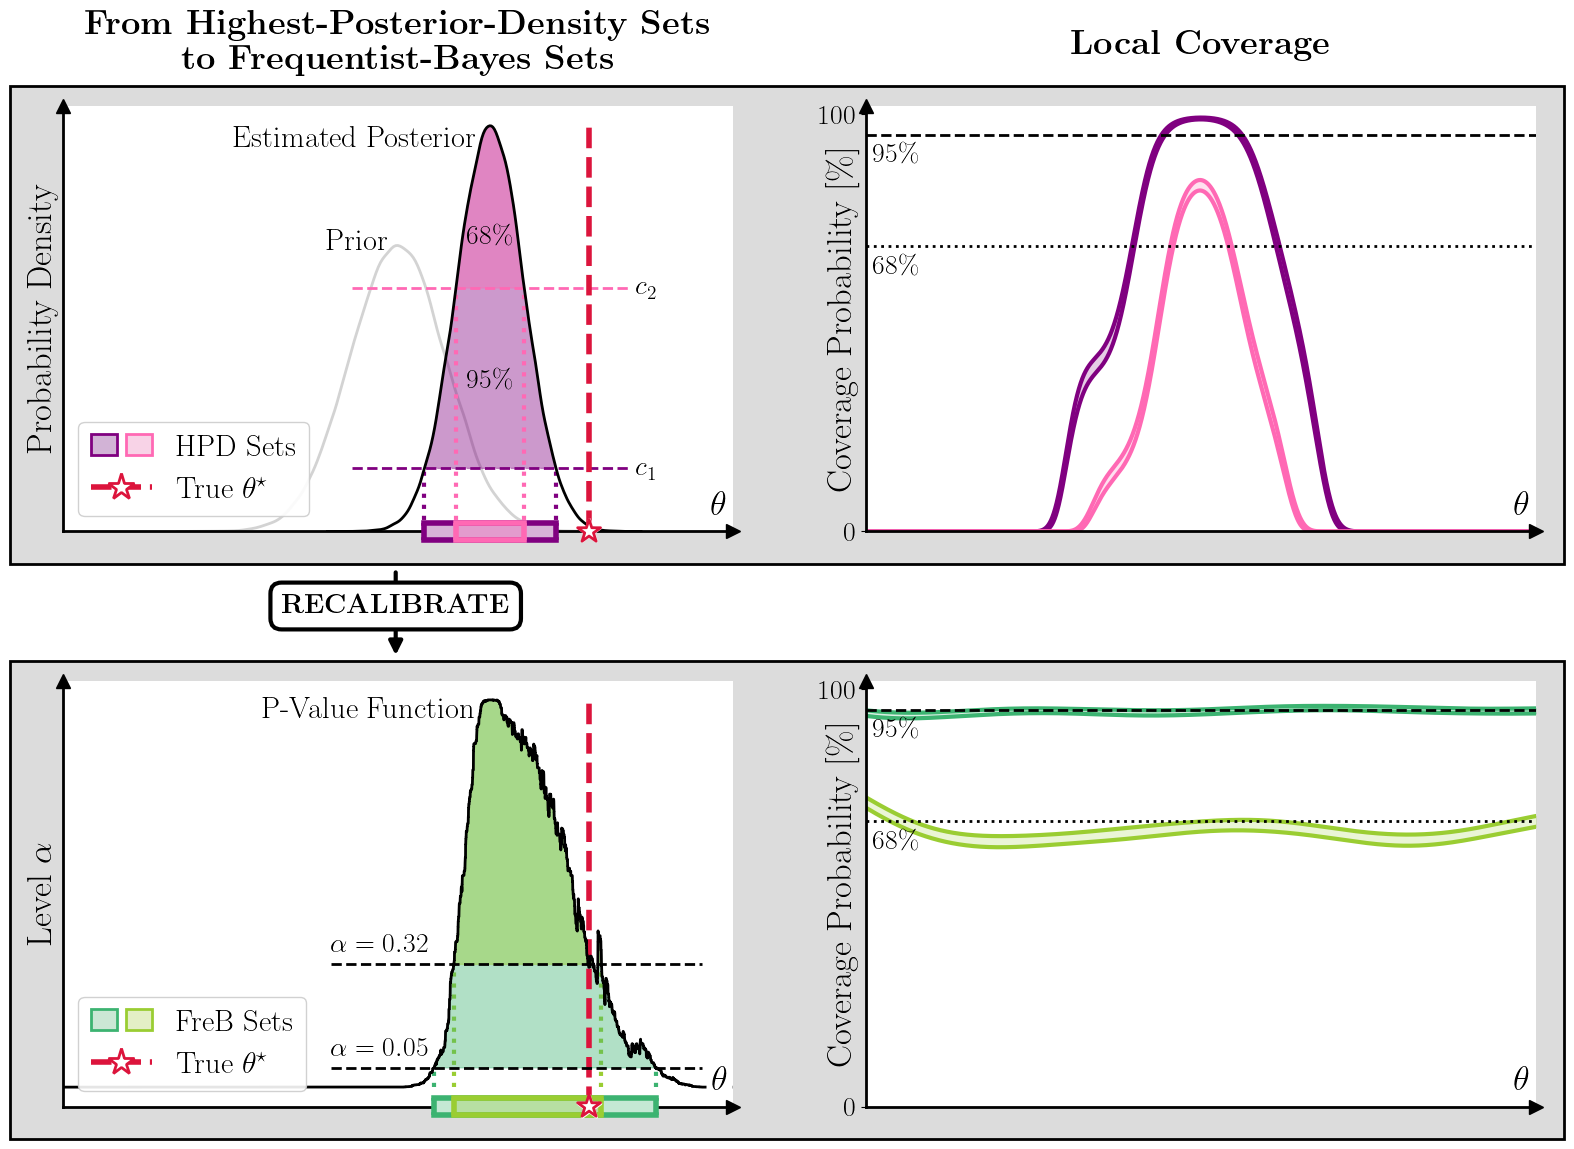

In [63]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

fig, ax = plt.subplots(2, 2, figsize=(19, 13))
plt.subplots_adjust(hspace=0.35)
plot1(ax[0][0])
plot2(ax[1][0])
plot4(ax[0][1])
plot3(ax[1][1])
fig.patches.append(patches.Rectangle((0.097, 0.085), 0.818, 0.368, transform=fig.transFigure, edgecolor='black', linewidth=2, facecolor="gainsboro", zorder=-1))
fig.patches.append(patches.Rectangle((0.097, 0.527), 0.818, 0.368, transform=fig.transFigure, edgecolor='black', linewidth=2, facecolor="gainsboro", zorder=-1))
fig.text(0.3, 0.495, r"{\bf RECALIBRATE}", fontsize=20, color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4', linewidth=3), zorder=20)
fig.add_artist(FancyArrowPatch(
    posA=(0.3, 0.523), posB=(0.3, 0.455),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=20, 
    color='black', linewidth=3, zorder=10
))
# ax[0].set_title(r'Neural Density Estimation and'+'\n'r'High-Posterior-Density Sets', size=25, pad=24)
ax[0][0].set_title(r'\textbf{From Highest-Posterior-Density Sets}'+'\n'+r'\textbf{to Frequentist-Bayes Sets}', size=25, pad=26)
ax[0][1].set_title(r'\textbf{Local Coverage}', size=25, pad=37)  # r"{\bf B)} " + 
# ax[1].set_title(r'Valid Scientific Inference via'+'\n'+r'Frequentist-Bayes Sets', size=25, pad=24)
# fig.text(0.16, 0.925, r"{\bf A)}", fontsize=25, color='black', ha='center', va='center', zorder=20)
# fig.text(0.639, 0.99, r"{\bf b)}", fontsize=25, color='black', ha='center', va='center', zorder=20)
plt.savefig('./outputs/schema_horizontal_words.pdf', bbox_inches='tight')
plt.show()